In [3]:
import seaborn as sns
sns.set_context("poster")

In [4]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas",
)
bike_sharing.frame

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0000,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0000,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0000,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0000,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014,119
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014,89
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014,90
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981,61


In [5]:
import pandas as pd
original_df = pd.read_csv("../hour.csv")

In [6]:
df = pd.concat([bike_sharing.frame, original_df[["dteday"]]], axis=1)

In [7]:
df["dteday"] = pd.to_datetime(df["dteday"])

In [8]:
hour_offset = df["hour"].apply(lambda x: pd.DateOffset(hours=x))

In [9]:
df["dteday"] = df["dteday"] + hour_offset

/tmp/ipykernel_224982/3820908605.py:1: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df["dteday"] = df["dteday"] + hour_offset


In [10]:
df = df.set_index("dteday")

In [11]:
df

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
dteday,,,,,,,,,,,,,
2011-01-01 00:00:00,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0000,16
2011-01-01 01:00:00,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0000,40
2011-01-01 02:00:00,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0000,32
2011-01-01 03:00:00,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0000,13
2011-01-01 04:00:00,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014,119
2012-12-31 20:00:00,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014,89
2012-12-31 21:00:00,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014,90


In [12]:
X, y = bike_sharing.frame.drop(columns="count"), bike_sharing.frame["count"]

In [13]:
X, y = df.drop(columns="count"), df["count"]

In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor

categorical_columns = ["season", "holiday", "workingday", "weather",]
numerical_columns = [
    "year", "month", "hour", "weekday", "temp", "feel_temp", "humidity", "windspeed"
]
preprocessing = ColumnTransformer(transformers=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ("scaler", StandardScaler(), numerical_columns),
])
model = make_pipeline(preprocessing, KNeighborsRegressor(n_neighbors=1))
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather']),
                                                 ('scaler', StandardScaler(),
                                                  ['year', 'month', 'hour',
                                                   'weekday', 'temp',
                                                   'feel_temp', 'humidity',
                                                   'windspeed'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=1))])

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, random_state=42, test_size=0.2
)

In [36]:
from sklearn.metrics import mean_absolute_error

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.0f} rentals")

MAE: 119 rentals


In [46]:
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit()
results = cross_validate(model, X, y, cv=cv)
results["test_score"]

array([0.53995921, 0.56550494, 0.54955008, 0.58937248, 0.54970848,
       0.5750184 , 0.55323522, 0.56421314, 0.55853266, 0.5056522 ])

In [47]:
from sklearn.model_selection import cross_validate, TimeSeriesSplit

cv = TimeSeriesSplit()
results = cross_validate(model, X, y, cv=cv)
results["test_score"]

array([-0.06406429,  0.01166642,  0.03483939,  0.12561052,  0.3277383 ])

In [49]:
lagged_target = pd.concat(
    [
        y,
        y.shift(1).rename("lagged_count_1h"),
        y.shift(2).rename("lagged_count_2h"),
        y.shift(3).rename("lagged_count_3h"),
        y.shift(24).rename("lagged_count_1d"),
        y.shift(24 + 1).rename("lagged_count_1d_1h"),
        y.shift(7 * 24).rename("lagged_count_7d"),
        y.shift(7 * 24 + 1).rename("lagged_count_7d_1h"),
        y.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        y.shift(1).rolling(24).max().rename("lagged_max_24h"),
        y.shift(1).rolling(24).min().rename("lagged_min_24h"),
        y.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        y.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        y.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
)

In [52]:
lagged_target.tail().loc[:, :"lagged_count_7d"]

,count,lagged_count_1h,lagged_count_2h,lagged_count_3h,lagged_count_1d,lagged_count_1d_1h,lagged_count_7d
dteday,,,,,,,
2012-12-31 19:00:00,119,122.0,164.0,214.0,102.0,125.0,26.0
2012-12-31 20:00:00,89,119.0,122.0,164.0,72.0,102.0,18.0
2012-12-31 21:00:00,90,89.0,119.0,122.0,47.0,72.0,23.0
2012-12-31 22:00:00,61,90.0,89.0,119.0,36.0,47.0,22.0
2012-12-31 23:00:00,49,61.0,90.0,89.0,49.0,36.0,12.0


In [76]:
lagged_target.head().loc[:, :"lagged_count_7d"]

,count,lagged_count_1h,lagged_count_2h,lagged_count_3h,lagged_count_1d,lagged_count_1d_1h,lagged_count_7d
dteday,,,,,,,
2011-01-01 00:00:00,16,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 01:00:00,40,16.0,NaN,NaN,NaN,NaN,NaN
2011-01-01 02:00:00,32,40.0,16.0,NaN,NaN,NaN,NaN
2011-01-01 03:00:00,13,32.0,40.0,16.0,NaN,NaN,NaN
2011-01-01 04:00:00,1,13.0,32.0,40.0,NaN,NaN,NaN


(15699.0, 15705.0)

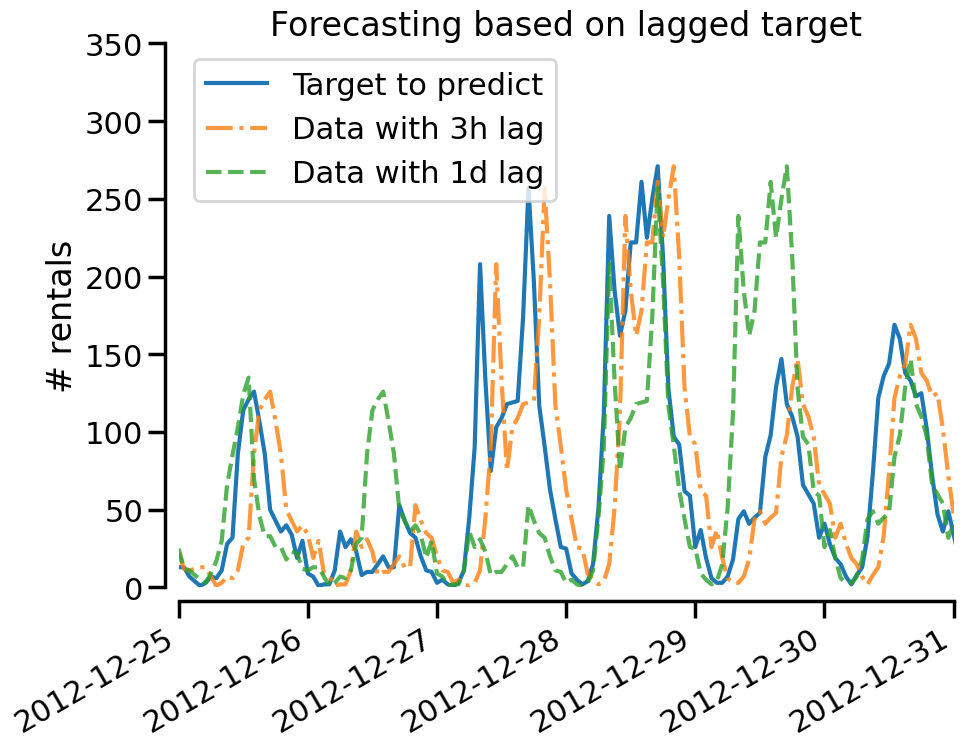

In [75]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(10, 8))
sns.despine(offset=10)
lagged_target.loc["2012-12-25":, "count"].plot(label="Target to predict", ax=ax)
lagged_target.loc["2012-12-25":, "lagged_count_3h"].plot(label="Data with 3h lag", alpha=0.8, linestyle="-.")
lagged_target.loc["2012-12-25":, "lagged_count_1d"].plot(label="Data with 1d lag", alpha=0.8, linestyle="--")
ax.legend()
ax.set_ylabel("# rentals")
ax.set_xlabel("")
ax.set_title("Forecasting based on lagged target")
ax.set_ylim(0, 350)
ax.set_xlim("2012-12-25", "2012-12-31")

In [77]:
import sklearn
import matplotlib
import pandas

sklearn.__version__

'1.2.dev0'

The following cell is not necessarily needed but can help avoid some slowdowns when running this notebooks on some machines.

In [78]:
import threadpoolctl
import joblib


n_physical_cpus = joblib.cpu_count(only_physical_cores=True)
threadpoolctl.threadpool_limits(limits=n_physical_cpus);
threadpoolctl.threadpool_info()

[{'user_api': 'blas',
  'internal_api': 'openblas',
  'prefix': 'libopenblas',
  'filepath': '/home/glemaitre/miniconda3/envs/dev/lib/python3.8/site-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so',
  'version': '0.3.20',
  'threading_layer': 'pthreads',
  'architecture': 'Haswell',
  'num_threads': 4},
 {'user_api': 'blas',
  'internal_api': 'openblas',
  'prefix': 'libopenblas',
  'filepath': '/home/glemaitre/miniconda3/envs/dev/lib/python3.8/site-packages/scipy.libs/libopenblasp-r0-41284840.3.18.so',
  'version': '0.3.18',
  'threading_layer': 'pthreads',
  'architecture': 'Haswell',
  'num_threads': 4},
 {'user_api': 'openmp',
  'internal_api': 'openmp',
  'prefix': 'libgomp',
  'filepath': '/home/glemaitre/miniconda3/envs/dev/lib/libgomp.so.1.0.0',
  'version': None,
  'num_threads': 4}]

## Data exploration on the Bike Sharing Demand dataset

We start by loading the data from the OpenML repository.

In [79]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas",
)
df = bike_sharing.frame
count = df["count"]

In [80]:
df

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0000,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0000,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0000,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0000,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014,119
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014,89
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014,90
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981,61


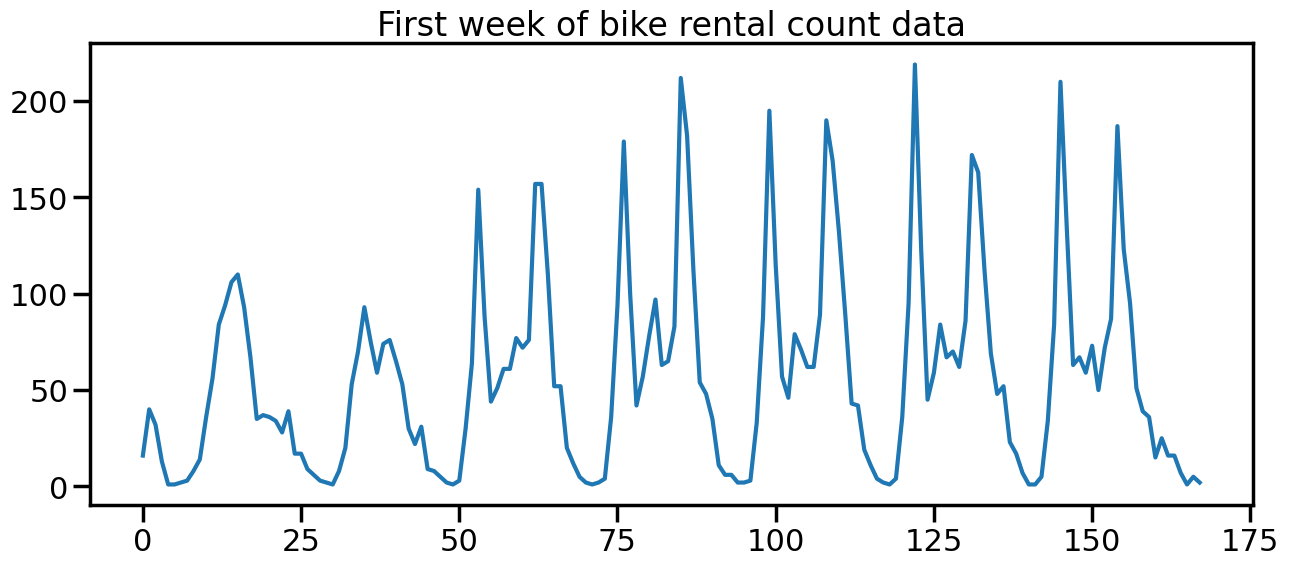

In [81]:
import matplotlib.pyplot as plt


count[:7 * 24].plot(figsize=(15, 6))
_ = plt.title("First week of bike rental count data")

In [82]:
count.describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: count, dtype: float64

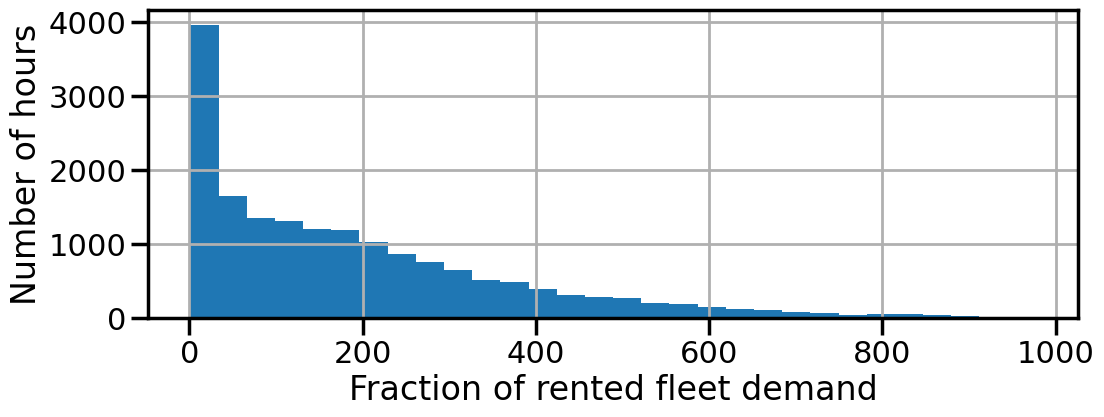

In [83]:
fig, ax = plt.subplots(figsize=(12, 4))
count.hist(bins=30, ax=ax)
_ = ax.set(
    xlabel="Fraction of rented fleet demand",
    ylabel="Number of hours",
)

## Time-series Forecasting via Tabularization

Let's consider the problem of predicting the demand at the next hour given past demands.

Since the demand is a continuous variable, one could intuitively use any regression model.

However we don't have the usual `(X_train, y_train)` dataset.

Instead we just have `y_train` demand data sequentially organized by time.


**TODO** draw a nice diagram here!

In [84]:
count.tail(10)

17369    247
17370    315
17371    214
17372    164
17373    122
17374    119
17375     89
17376     90
17377     61
17378     49
Name: count, dtype: int64

In [85]:
import pandas as pd

lagged_df = pd.concat(
    [
        count,
        count.shift(1).rename("lagged_count_1h"),
        count.shift(2).rename("lagged_count_2h"),
        count.shift(3).rename("lagged_count_3h"),
        count.shift(24).rename("lagged_count_1d"),
        count.shift(24 + 1).rename("lagged_count_1d_1h"),
        count.shift(7 * 24).rename("lagged_count_7d"),
        count.shift(7 * 24 + 1).rename("lagged_count_7d_1h"),
        count.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        count.shift(1).rolling(24).max().rename("lagged_max_24h"),
        count.shift(1).rolling(24).min().rename("lagged_min_24h"),
        count.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        count.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        count.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
)
lagged_df.tail(10)

,count,lagged_count_1h,lagged_count_2h,lagged_count_3h,lagged_count_1d,lagged_count_1d_1h,lagged_count_7d,lagged_count_7d_1h,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_max_7d,lagged_min_7d
17369,247,203.0,224.0,157.0,160.0,169.0,70.0,135.0,93.500000,224.0,1.0,67.732143,271.0,1.0
17370,315,247.0,203.0,224.0,138.0,160.0,46.0,70.0,97.125000,247.0,1.0,68.785714,271.0,1.0
17371,214,315.0,247.0,203.0,133.0,138.0,33.0,46.0,104.500000,315.0,1.0,70.386905,315.0,1.0
17372,164,214.0,315.0,247.0,123.0,133.0,33.0,33.0,107.875000,315.0,1.0,71.464286,315.0,1.0
17373,122,164.0,214.0,315.0,125.0,123.0,26.0,33.0,109.583333,315.0,1.0,72.244048,315.0,1.0
17374,119,122.0,164.0,214.0,102.0,125.0,26.0,26.0,109.458333,315.0,1.0,72.815476,315.0,1.0
17375,89,119.0,122.0,164.0,72.0,102.0,18.0,26.0,110.166667,315.0,1.0,73.369048,315.0,1.0
17376,90,89.0,119.0,122.0,47.0,72.0,23.0,18.0,110.875000,315.0,1.0,73.791667,315.0,1.0
17377,61,90.0,89.0,119.0,36.0,47.0,22.0,23.0,112.666667,315.0,1.0,74.190476,315.0,1.0
17378,49,61.0,90.0,89.0,49.0,36.0,12.0,22.0,113.708333,315.0,1.0,74.422619,315.0,1.0


Whatch out however, the first lines have undefined values because their own past is unknown. This depends on how much lag we used:

In [86]:
lagged_df.head(10)

,count,lagged_count_1h,lagged_count_2h,lagged_count_3h,lagged_count_1d,lagged_count_1d_1h,lagged_count_7d,lagged_count_7d_1h,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_max_7d,lagged_min_7d
0,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32,40.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,32.0,40.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,13.0,32.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,1.0,13.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2,1.0,1.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,3.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,14,8.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can now separate the lagged features in a matrix `X` and the target variable (the counts to predict) in an array of the same first dimension `y`.

In [87]:
lagged_df = lagged_df.dropna()

In [88]:
X = lagged_df.drop("count", axis="columns")
y = lagged_df["count"]

In [89]:
X.shape

(17210, 13)

In [90]:
y.shape

(17210,)

## Naive Regression of the Next Hour Bike Demand

Let's randomly split our tabularized dataset to train a gradient boosting regression tree (GBRT) model and evaluate it using the [Mean Absolute Percentage Error](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-percentage-error).

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = HistGradientBoostingRegressor().fit(X_train, y_train)

In [92]:
from sklearn.metrics import mean_absolute_percentage_error


y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.39189740362235315

### Questions

- Why this way of evaluating the predictive performance of our model naive?
    - Hint: this train-test split is only valid for *independent and identically distributed data*.
- What should be done instead?

## Proper Next Hour Forecasting Evaluation

Let's use a proper evaluation splitting strategies that takes into account the temporal structure of the dataset to **evaluate our model's ability to predict data points in the future** (to avoid cheating by reading values from the lagged features in the training set).


![TimeSeriesSplit](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png)

The above diagram has 4 splits, a gap of 0 time steps and no limit on the train size.

In [93]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=3,            # to keep the notebook fast enough on common laptops
    gap=48,                # 2 days data gap between train and test
    max_train_size=10000,  # quite arbitrary, to keep train sets of comparable sizes
    test_size=3000,        # need at lest this to hope for 2 or 3 digits of precision in scores
)

In [94]:
all_splits = list(ts_cv.split(X, y))
len(all_splits)

3

In [95]:
train_idx, test_idx = all_splits[0]
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

model = HistGradientBoostingRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.44300751539296973

The error rate of this model is better than our naive shuffling train-test split. This is quite expected but maybe the first split is easier to predict (more regular) than the others. Let's assess this variability of our error evaluation with proper cross-validation:

In [96]:
from sklearn.model_selection import cross_val_score


cv_mape_scores = -cross_val_score(model, X, y, cv=ts_cv, scoring="neg_mean_absolute_percentage_error")
cv_mape_scores

array([0.44300752, 0.27772182, 0.3697178 ])

The variability accross splits is quite large! In a real life setting it would be advised to use more splits to better assess the variability. Let's report the mean CV scores and their standard deviation from now on.

In [97]:
print(f"CV MAPE: {cv_mape_scores.mean():.3f} ± {cv_mape_scores.std():.3f}")

CV MAPE: 0.363 ± 0.068


To get a finer evaluation of our models we can compute and report several cross-validation metrics at once using a dedicated helper function:

In [108]:
import numpy as np
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error


def evaluate(model, X, y):
    def score_func(estimator, X, y):
        y_pred = estimator.predict(X)
        return {
            "mean_absolute_error": mean_absolute_error(y, y_pred),
            "mean_pinball_05_loss": mean_pinball_loss(y, y_pred, alpha=0.05),
            "mean_pinball_50_loss": mean_pinball_loss(y, y_pred, alpha=0.50),
            "mean_pinball_95_loss": mean_pinball_loss(y, y_pred, alpha=0.95),
        }
    cv = TimeSeriesSplit(n_splits=5, gap=48, max_train_size=10_000, test_size=3_000)
    cv_results = cross_validate(model, X, y, cv=cv, scoring=score_func)
    for key, value in cv_results.items():
        if key.startswith("test_"):
            print(f"{key[5:]}: {value.mean():.3f} ± {value.std():.3f}")

In [111]:
from sklearn.ensemble import HistGradientBoostingRegressor


gbrt_mse = HistGradientBoostingRegressor(loss="squared_error")
evaluate(gbrt_mse, X, y)

mean_absolute_error: 40.500 ± 9.475
mean_pinball_05_loss: 15.306 ± 3.453
mean_pinball_50_loss: 20.250 ± 4.738
mean_pinball_95_loss: 25.194 ± 11.798


In [112]:
gbrt_poisson = HistGradientBoostingRegressor(loss="poisson")
evaluate(gbrt_poisson, X, y)

mean_absolute_error: 41.149 ± 10.268
mean_pinball_05_loss: 14.352 ± 3.477
mean_pinball_50_loss: 20.574 ± 5.134
mean_pinball_95_loss: 26.796 ± 12.694


### Analysis

Compare the results of those first two models, what do you observe?

- which model has the best MAPE?
- which model has the best RMSE?
- in your opinion, since the `squared_error` model directly optimize for the RMSE objective, do you expect to always reach the best RMSE? Why?

### Exercise: baseline (generalized) linear models

- Evaluate `sklearn.linear_model.Ridge` and `sklearn.linear_model.PoissonRegressor` on the previous feature array. Here the data has many more samples than features so it is advised to use a low enough value for the regularization parameter `alpha` of both models, e.g. `alpha=0.0001` but feel free to try other values.
- For `Ridge`, it is recommended to use `solver="lsqr"` which has proven to be more numerically stable (and fast) than alternatives on this dataset.
- Which of the 2 models performs the best in terms of MAPE or Mean Squared Error?
- Are those models competitive in terms of training speed and cross-validated metrics compared to the tree based models?



In [121]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

model = make_pipeline(StandardScaler(), Ridge(alpha=1e-4))
evaluate(model, X, y)

mean_absolute_error: 41.435 ± 4.303
mean_pinball_05_loss: 20.642 ± 2.089
mean_pinball_50_loss: 20.717 ± 2.151
mean_pinball_95_loss: 20.793 ± 2.738


### Solution

In [122]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-5, 5, num=100)
model = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))
evaluate(model, X, y)

mean_absolute_error: 41.446 ± 4.305
mean_pinball_05_loss: 20.642 ± 2.090
mean_pinball_50_loss: 20.723 ± 2.152
mean_pinball_95_loss: 20.803 ± 2.743


In [123]:
from sklearn.linear_model import PoissonRegressor

model = make_pipeline(StandardScaler(), PoissonRegressor(alpha=1e-4))
evaluate(model, X, y)

mean_absolute_error: 99.768 ± 26.893
mean_pinball_05_loss: 67.561 ± 27.115
mean_pinball_50_loss: 49.884 ± 13.446
mean_pinball_95_loss: 32.208 ± 6.230


We observe that the `PoissonRegressor` model is much worse than the `Ridge` model when trained on the raw features but even the latter is not very good (e.g. a bit lower than 60% MAPE), this is much worse than the Gradient Boosting based models. One reason could be that tree-based model can naturally model non-linear statistical association between the raw `X` features and the `y` target values.

**Note**: the solver for `PoissonRegressor` does not seem to work at all the raw features. I suspect ill-conditioning of the resulting optimization problem causing the `l-BFGS` solver to fail (silently!) in this case. There is work in progress to plug alternative solvers for this estimator in scikit-learn.


## Non-linear Feature Engineering with `SplineTransformer`

Let's now consider a non-linear feature transformation (expansion) using spline functions. We hope to make the combination (spline transformer + linear model) more expressive than a linear model trained directly on the raw features.


Here is are the dimensions of the feature matrix before and after transformation by the `SplineTransformer` of scikit-learn:

In [104]:
X.shape

(17210, 13)

In [105]:
from sklearn.preprocessing import SplineTransformer


SplineTransformer(n_knots=10, degree=3).fit_transform(X).shape

(17210, 156)


You can observe that the spline-based transformation created many more derived features than originally. With this additional expressive power, one could hope that the models are no longer under fitting.

Each input feature is expanded into several features via a polynomial transformation (depending on the number of spline knots and degrees). Contrary to traditional polynomial transformation, splines features are bounded and non-monotonic:

![Spline Features (4 knots)](https://scikit-learn.org/stable/_images/sphx_glr_plot_polynomial_interpolation_002.png)


### Exercise

- Define and evaluate a pipeline of `sklearn.preprocessing.SplineTransformer` and `sklearn.linear_model.PoissonRegressor` on the same problem.
- You can use the `sklearn.pipeline.make_pipeline` function to combine the two estimators into a compound non-linear regression model that does the spline expansion internally.


**Note**: the current solver of `PoissonRegressor` (L-BFGS) is known to have trouble on this kind of features but I don't have a good solution for now, feel free to keep `max_iter=100` and silence the warning hoping that convergence is good enough.

- What do you observe?
- Are this compound model better than fitting `sklearn.linear_model.PoissonRegressor`  directly on `X` and `y`


In [106]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline


# TODO: put your code here




















### Solution

In [120]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline


pipeline = make_pipeline(
    SplineTransformer(n_knots=12, degree=3),
    PoissonRegressor(alpha=1e-6, max_iter=300),
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    evaluate(pipeline, X, y)

mean_absolute_error: 69.270 ± 42.995
mean_pinball_05_loss: 25.386 ± 17.528
mean_pinball_50_loss: 34.635 ± 21.498
mean_pinball_95_loss: 43.884 ± 28.616
